## LAB Assignment
Please finish the **Exercise** and answer **Questions**.
### Exercise (100 Points)
In this lab, we are about to find a shortest path with collision avoidance using MDP. We will model the problem as a MDP problem and use **value iteration** or **policy iteration** algorithm to solve it.

#### Environment Data

- Environment: `map_matrix.npy` has environment data. You need to use `numpy` to load  it.
  - <font color=black>White block</font>: an agent, for example, a robot
  - <font color=red>Red block</font>: destination
  - <font color=green>Green block</font>: obstacle


![image-20220809121750229](images/image-20220809121750229.png)

- $\mathscr{R}$ Reward: reward is implemented in code and it only concerns the next state:
  - wall: $-1$
  - destination: 0
  - else: $-0.1$
- $\mathscr{P}$ State transformation: next state is deterministic when taking an action under a certain state.
- $\pi$ Initial policy: each direction (up, right, bottom, left) has equal probability.

#### Display

We have several methods for you to display policy, state value and path on map

```python
def display_policy()
def display_v()
def display_path()
```



#### Implementation code
##### Initialize $\mathcal{S}$, $\mathcal{A}$, $\mathcal{R}$, $\mathcal{P}$

In [1]:
import numpy as np
# import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:
# import numpy as np
# import torch
# np.array = torch.Tensor
# np.ndarray = torch.TensorType
# np.array.astype = torch.Tensor.to
# np.array.copy = torch.Tensor.clone
# torch.set_default_tensor_type(torch.cuda.FloatTensor)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


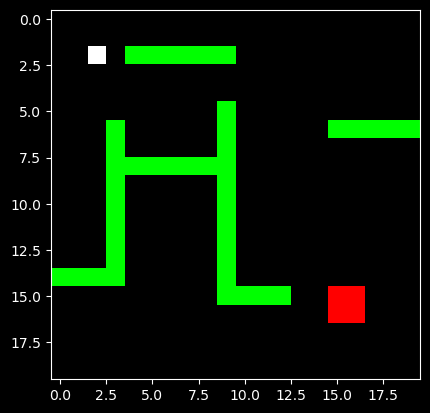

In [2]:
map_matrix = np.load("map_matrix.npy")
plt.imshow(map_matrix)
plt.show()
# map_matrix = np.array(map_matrix)
# map_matrix

In [3]:
MAX_Y = map_matrix.shape[0]
MAX_X = map_matrix.shape[1]
noS = MAX_Y * MAX_X
noA = 4

In [4]:
# A, defining action variables
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

# S, a sequence of number rather than coordinates
S = range(noS)

# reward
reward_blank = -0.1  #for every step -1 in other states
reward_wall = -1  # for wall
reward_goal = 0  # for destination

# 收集wall goal的所有状态，
wall = []
goal = []
start = None
for y in range(MAX_Y):
    for x in range(MAX_X):
        if list(map_matrix[y][x]) == [0., 30., 0.]:
            wall.append(y * MAX_X + x)
        elif list(map_matrix[y][x]) == [255., 0., 0.]:
            goal.append(y * MAX_X + x)
        elif list(map_matrix[y][x]) == [255., 255., 255.]:
            start = (y, x)
print("--> State of walls:", wall)
print("--> State of destination:", goal)

# P[s][a] = (state transition probability, next state, reward, done)
P = dict() # 二维字典
grid = np.arange(noS).reshape(map_matrix.shape[0:2])
it = np.nditer(grid, flags=['multi_index'])

while not it.finished:
    s = it.iterindex
    y, x = it.multi_index
    P[s] = dict()
    #if (terminal_state(s)):
    if (s in goal):  #s in terminal_state:
        P[s][UP] = (1.0, s, reward_goal, True)
        P[s][RIGHT] = (1.0, s, reward_goal, True)
        P[s][DOWN] = (1.0, s, reward_goal, True)
        P[s][LEFT] = (1.0, s, reward_goal, True)
    else: # 如果不是目标点
        ns_up = s if y == 0 else s - MAX_X
        ns_right = s if x == (MAX_X - 1) else s + 1
        ns_down = s if y == (MAX_Y - 1) else s + MAX_X
        ns_left = s if x == 0 else s - 1

        if s in goal:
            rw = reward_goal
        elif s in wall:
            rw = reward_wall
        else:
            rw = reward_blank

        P[s][UP] = (1.0, ns_up, rw, ns_up in goal)
        P[s][RIGHT] = (1.0, ns_right, rw, ns_right in goal)
        P[s][DOWN] = (1.0, ns_down, rw, ns_down in goal)
        P[s][LEFT] = (1.0, ns_left, rw, ns_left in goal)
    it.iternext()

print('--> Number of states in grid: ' + str(noS))
print('--> Number of action options in each state:' + str(noA))
print("--> Transition probabilities matrix(prob, next_state, reward, is_done)：")
print(P[0]) # 目前概率都是1，而且只有一项。

--> State of walls: [44, 45, 46, 47, 48, 49, 109, 123, 129, 135, 136, 137, 138, 139, 143, 149, 163, 164, 165, 166, 167, 168, 169, 183, 189, 203, 209, 223, 229, 243, 249, 263, 269, 280, 281, 282, 283, 289, 309, 310, 311, 312]
--> State of destination: [315, 316, 335, 336]
--> Number of states in grid: 400
--> Number of action options in each state:4
--> Transition probabilities matrix(prob, next_state, reward, is_done)：
{0: (1.0, 0, -0.1, False), 1: (1.0, 1, -0.1, False), 2: (1.0, 20, -0.1, False), 3: (1.0, 0, -0.1, False)}


##### Optimization Approach
You need to implement one of them

+ Value Iteration

In [5]:
import logging
logging.basicConfig(level = logging.INFO,format = '%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [6]:
import torch
from tqdm import trange
def value_iteration(P,theta=0.0001, discount_factor=1.0, maxiter=1000):
    """
    Value iteration

    :param theta: threshold to stop iteration
    :param discount_factor: the same as discount factor in formula
    :return: a policy and a state-value matrix V
    """
    
    def get_policy(V):
        policy = np.zeros([noS, noA])
        for s in S:
            best_action = None
            for action in range(noA):
                prob, next_state, reward, done = P[s][action]
                # policy[s, action] = V[next_state]-V[s] # 用累计奖励的差值来判断策略选择概率。
                if best_action is None or V[next_state] > best_action[1]:
                    best_action = action, V[next_state]
            policy[s] = np.eye(noA)[best_action[0]] # 选择最大的那个action，其他的action的概率为0。
            # # 归一化操作
            # if np.sum(policy[s]) > theta:
            #     policy[s] = policy[s]/np.sum(policy[s])
            # else:
            #     policy[s] = np.ones(noA)/noA
        return policy
                    
    V = np.zeros(noS)
    # while True:
    policy = None
    for step in trange(maxiter):
        delta = 0 # 改变量，用于判断是否收敛。 因为是折扣，不知道什么时候结束。
        policy = get_policy(V)
        for s in S:
            for action in range(noA):
                pi = policy[s, action]
                prob, next_state, reward, done = P[s][action]
                change = pi * (reward + discount_factor * V[next_state])
                V[s] += change
                delta = max(abs(change), delta)
            
        if abs(delta)<theta:
            logger.info(f"价值迭代收敛，迭代次数为：{step}")
            break


    # return get_policy(V), V
    return policy, V

+   Policy Iteration

In [7]:
def policy_eval(policy_matrix, P_matrix, discount_factor=1.0, theta=0.00001):
    # Start with a random (all 0) value function
    V = np.zeros(noS)
    while True:
        delta = 0
        # TODO: finish evaluation part
        pass

        if delta < theta:
            break
    return np.array(V)


def policy_improvement(P_matrix, policy_eval_fn=policy_eval, discount_factor=1.0):
    def one_step_lookahead(state, V_matrix):
        A = np.zeros(noA)

        # TODO: calculate next states' values after taking different actions
        pass

        return A

    # Start with a random policy
    policy_now = np.ones([noS, noA]) / noA

    while True:
        # Evaluate the current policy
        V = policy_eval_fn(policy_now, P_matrix, discount_factor)

        # Will be set to false if we make any changes to the policy
        policy_stable = True

        # For each state...
        for s in range(noS):
            # TODO: The best action we would take under the current policy
            pass

            # TODO: Find the best action by one-step lookahead
            # Ties are resolved arbitarily
            pass

            # TODO: Greedily update the policy
            pass

        # If the policy is stable we've found an optimal policy. Return it
        if policy_stable:
            return policy_now, V

In [8]:
# iteration = policy_improvement
iteration = value_iteration
# policy, v = iteration(P, maxiter=250)
policy, v = iteration(P, maxiter=14096)

100%|██████████| 14096/14096 [00:32<00:00, 438.54it/s]


In [13]:
policy.shape

(400, 4)

#### Display

In [10]:
# display modules
def display_policy(policy_map: np.ndarray, des=((15, 16), (15, 15), (16, 15), (16, 16))):
    """
    Display policy in a vector field
    :param des: destination, for dying quiver
    :param policy_map: your policy map where each position is a number standing for an action
    :return:
    """

    def phrase_action(action: int):
        if action == 0:
            return 0, 1
        if action == 1:
            return 1, 0
        if action == 2:
            return 0, -1
        if action == 3:
            return -1, 0
        return 0, 0

    des = np.asarray(np.copy(des))

    X, Y = policy_map.shape
    grid_X = np.arange(X).reshape(-1, 1).repeat(Y, axis=1)
    grid_Y = np.arange(Y).reshape(1, -1).repeat(X, axis=0)
    direct_X, direct_Y = [], []
    C = []
    for x_row in list(zip(grid_X, grid_Y)):
        for p in tuple(zip(x_row[0], x_row[1])):
            direct_x, direct_y = phrase_action(policy_map[p[0], p[1]])
            direct_X.append(direct_x)
            direct_Y.append(direct_y)
            if des is not None:
                C.append(np.sum(np.abs(p - des)))
    fig = plt.figure(figsize=(8, 8))
    ax = plt.gca()
    ax.xaxis.set_ticks_position('top')  #将X坐标轴移到上面
    ax.invert_yaxis()  #反转Y坐标轴
    plt.quiver(grid_X, grid_Y, direct_X, direct_Y, 0 if len(C) == 0 else C)
    plt.show()


def display_v(V: np.ndarray, map_m: np.ndarray):
    """
    display state value in heat map
    :param map_m: 2D map matrix corresponding to v
    :param V: state value, 1D
    :return:
    """

    heatmap = V.reshape(map_m.shape[0:2])
    plt.imshow(heatmap, cmap=plt.cm.autumn)
    plt.colorbar()
    plt.show()


def display_path(policy_map, map_m, departure, des, max_iter=100):
    """

    :param policy_map: policy
    :param map_m: map
    :param departure: start point
    :param des: destination
    :return:
    """
    map_m = np.copy(map_m)

    now_y, now_x = departure
    iter_n = 0
    while now_y * MAX_X + now_x not in des:
        if iter_n > max_iter:
            break
        map_matrix[now_y, now_x, :] = np.array([151, 255, 255])
        if UP == policy_map[now_y, now_x]:
            now_y = now_y - 1
        elif RIGHT == policy_map[now_y, now_x]:
            now_x = now_x + 1
        elif DOWN == policy_map[now_y, now_x]:
            now_y = now_y + 1
        elif LEFT == policy_map[now_y, now_x]:
            now_x = now_x - 1
        now_y = (now_y + MAX_Y) % MAX_Y
        now_x = (now_x + MAX_X) % MAX_X
        map_m[now_y, now_x, :] = 120
        plt.imshow(map_m)
        plt.show()
        display.clear_output(wait=True)

        iter_n += 1

Grid Policy (0=up, 1=right, 2=down, 3=left):


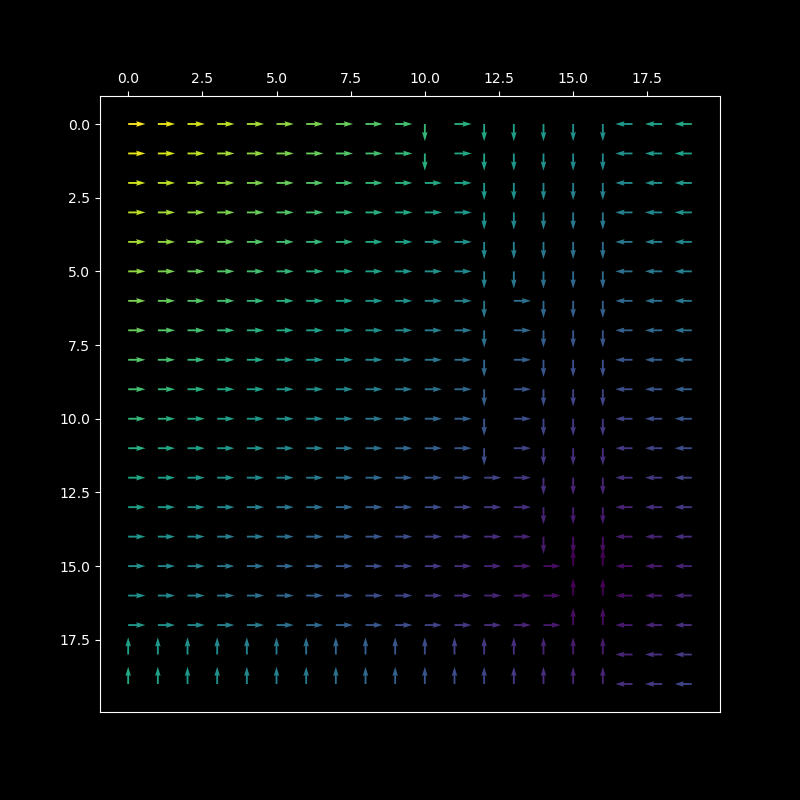

In [34]:
print("Grid Policy (0=up, 1=right, 2=down, 3=left):")
grid_policy = np.reshape(np.argmax(policy, axis=1), map_matrix.shape[0:2])
display_policy(grid_policy.T)

State value:


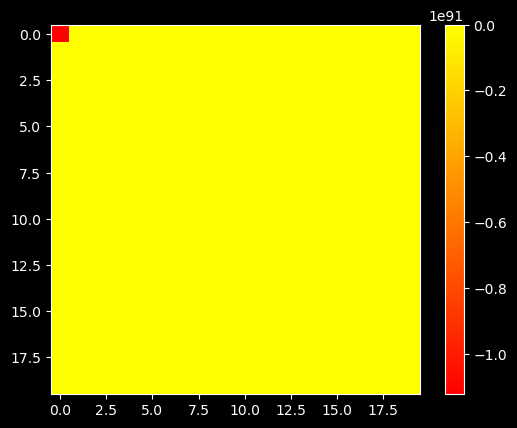

In [11]:
print("State value:")
display_v(v, map_matrix)

In [14]:
# %matplotlib widget
from IPython import display
display_path(grid_policy, map_matrix, start, goal)

NameError: name 'grid_policy' is not defined